https://wassersteinwormhole.readthedocs.io/en/latest/tutorial/Wormhole_Tutorial.html

https://github.com/dpeerlab/WassersteinWormhole/blob/main/wassersteinwormhole/SpatialWormhole.py

## Import

In [1]:
#from wassersteinwormhole.SpatialWormhole import SpatialWormhole
#from wassersteinwormhole.DefaultConfig import SpatialDefaultConfig
import anndata
import numpy as np
import scanpy as sc
import os

In [2]:
import jax
print(jax.devices())

[CudaDevice(id=0)]


In [2]:
output_path = "output/all_counts_one_patient"

## Load

In [4]:
input_path = "../input data/crca_xenium.h5ad"
adata = sc.read_h5ad(input_path)

### Subset of samples

In [5]:
patients_to_keep = ['k']
adata = adata[adata.obs['patient_id'].isin(patients_to_keep)].copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 239098 × 380
    obs: 'cell_id', 'name', 'slide', 'tissue_region', 'patient_id', 'crca_id', 'crca_patient_id', 'msi_status', 'stage', 'age', 'sex', 'KRAS', 'BRAF', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segm_meth', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'transcript_density', 'mean_neighbor_dist', 'scvi130_nb_leiden_2.5', 'scvi130_nb_leiden_3.8', 'anno_notes', 'celltype', 'celltype_sub', 'CN', 'Neutrophil', 'Niche'
    uns: 'colors', 'delaunayr50_nb', 'delaunayr50_neighbors', 'log1p', 'nichecompass_umap', 'scvi130_nb', 'scvi130_nb_leiden_1_rank', 'scvi130_nb_umap', 'spatialdata_attrs'
    obsm: 'delaunayr50', 'nichecompass_umap', 'norm_pca', 'norm_pca_nb_umap', 'scvi', 'scvi130_nb_umap', 'spatial'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_s

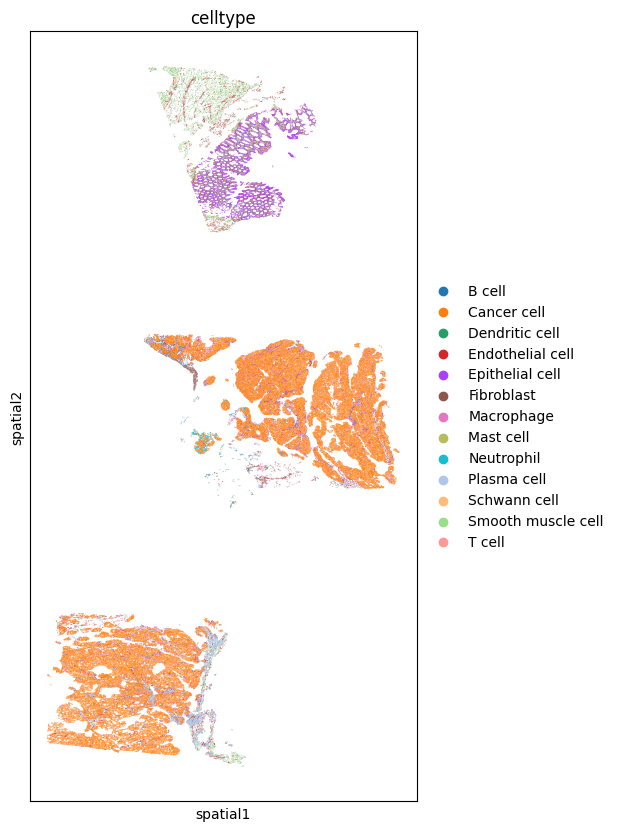

In [9]:
fig = sc.pl.embedding(
    adata,
    basis="spatial",
    color="celltype",
    show=False,
    return_fig=True
)

fig.set_size_inches(5, 10)
fig.show()

## WassersteinWormhole

In [ ]:
# 8 cores, 128 GB, a100

In [10]:
# option 1: raw counts + scale='min_max_total'
# option 2: normalized and log transformed counts + scale=None
adata.X = adata.layers['norm'].copy()

In [11]:
n_neighbors = 15

# config = SpatialDefaultConfig() # default

In [12]:
config = SpatialDefaultConfig().replace(
    # --- Input keys ---
    spatial_key='spatial',           
    rep_key=None,       # or nothing (high costs) ??
    batch_key='name',       # knn per sample

    # --- Normalization & scaling ---
    scale=None,      # min_max_total if using raw counts, None if using normalized counts     !!!!!!!!!!!
    # scale_ot=True,                   
    # factor=1.0,                      

    # --- OT / Sinkhorn parameters ---
    # eps_enc=0.02,                    # encoder OT
    # eps_dec=0.02,                    # decoder OT
    # num_sinkhorn_iter=200,          
    # coeff_dec=0.1,                   

    # --- Architettura del modello ---
    # num_heads=4,                     # attention multi-head (Transformer)
)

In [13]:
# initialize model
model = SpatialWormhole(
    adata_train=adata,
    k_neighbours=n_neighbors,        
    config=config,
)

Pre-computing neighbor indices and caching expression data...
Largest niche found has 15 neighbors. This will be the padding size.
Decoder generating point-clouds of size:  15
Calculating OT scale value from a sample of niches...


Calculating max of max distances (metric: squared Euclidean): 100%|██████████| 100/100 [00:00<00:00, 299.40it/s]

Using OT scale value of 1.62e+02
Using num_sinkhorn_iter = 200


In [14]:
# train model
model.train(
    training_steps=10000,
    batch_size=128,
    init_lr=1e-4,
    decay_steps=2000,
    verbose=500
)

Starting training loop using adam...


 enc_loss: 6.151e-04 dec_loss: 1.580e-01 enc_corr: 0.986: 100%|██████████| 10000/10000 [42:45<00:00,  3.90it/s]


In [15]:
# save model does not work
# model.save(os.path.join(output_path, 'wormhole_niches.pkl'))

In [16]:
# niches embeddings computation
cell_indices = np.arange(adata.n_obs)
niche_embeddings = model.encode(cell_indices) # cells x embedding_dim

Encoding: 100%|██████████| 934/934 [00:57<00:00, 16.31it/s]


In [17]:
# save embeddings in anndata
adata.obsm['wormhole_niche_embedding'] = niche_embeddings

In [18]:
adata.write(os.path.join(output_path, 'adata_niche_embedding.h5ad'))

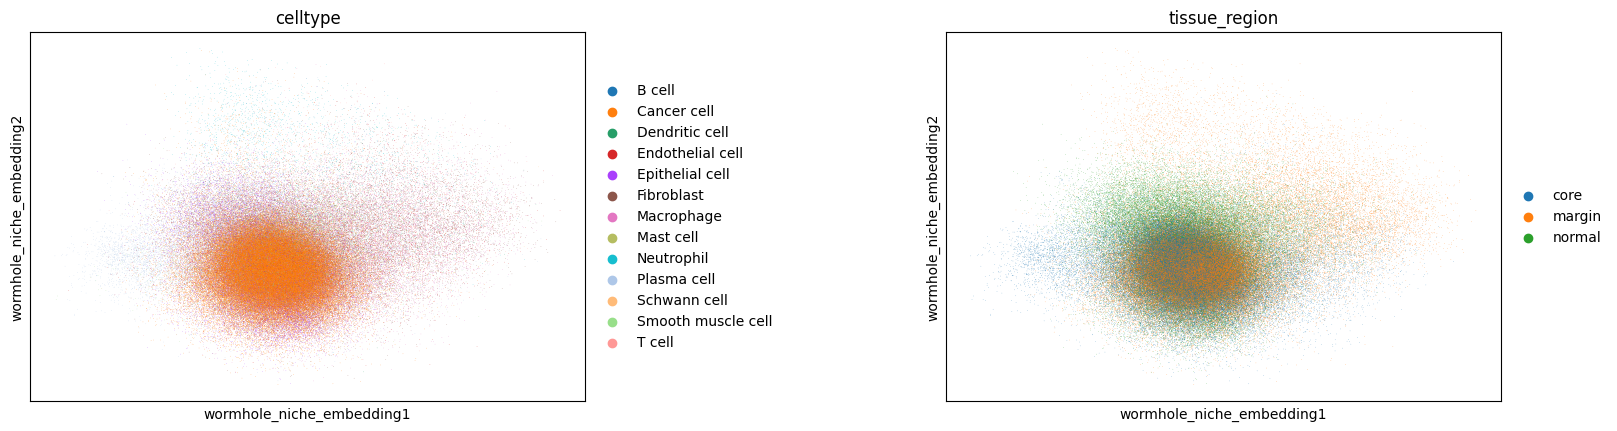

In [19]:
sc.pl.embedding(
    adata,
    basis="wormhole_niche_embedding",
    color=["celltype","tissue_region"],
    wspace=0.5
)

## Downstream analysis

In [ ]:
# change server here

In [3]:
adata = sc.read_h5ad(os.path.join(output_path, 'adata_niche_embedding.h5ad'))

In [4]:
key = 'wormhole_neighbors'
sc.pp.neighbors(adata, use_rep='wormhole_niche_embedding', key_added=key)
sc.tl.umap(adata, neighbors_key=key)

/home/rossi/.conda/envs/WassersteinWormhole/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
adata.write(os.path.join(output_path, 'adata_niche_embedding.h5ad'))

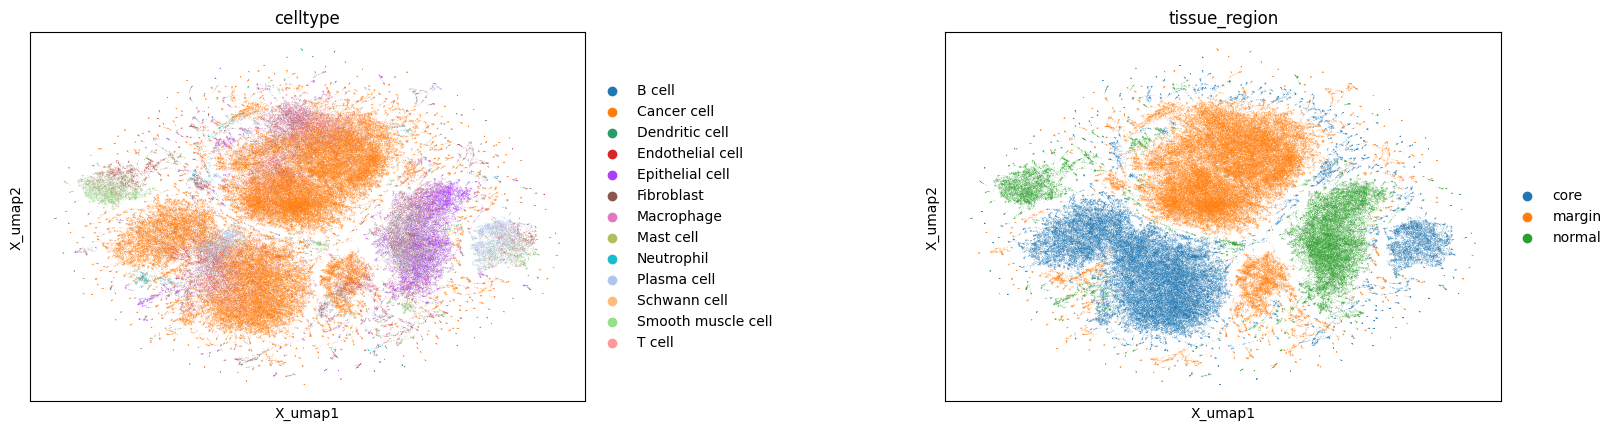

In [6]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=["celltype","tissue_region"],
    wspace=0.5
)